#### 必要なライブラリのインポート

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import japanize_matplotlib
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from tqdm.notebook import tqdm


#### 共通関数のインポート
著者が学習用、予測用、学習用ログ解析用、図示用の関数を用意してくださっているのでそちらを利用する

In [13]:
!git clone https://github.com/makaishi2/pythonlibs.git

from pythonlibs.torch_lib1 import *

fatal: destination path 'pythonlibs' already exists and is not an empty directory.


#### GPUの確認

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### データの準備

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations (e.g., resizing, normalization)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor()
])

# Define datasets
train_dataset = datasets.ImageFolder(root='/usr/src/tiny-imagenet-200/train', transform=transform)
test_dataset = datasets.ImageFolder(root='/usr/src/tiny-imagenet-200/test', transform=transform)
val_dataset = datasets.ImageFolder(root='/usr/src/tiny-imagenet-200/val_reorganized', transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

print(f"Train loader has {len(train_loader.dataset)} images.")
print(f"Test loader has {len(test_loader.dataset)} images.")
print(f"Validation loader has {len(val_loader.dataset)} images.")


Train loader has 100000 images.
Test loader has 10000 images.
Validation loader has 10000 images.


import os
import shutil
import pandas as pd

# Define paths
val_images_path = '/usr/src/tiny-imagenet-200/val/images'
val_annotations_path = '/usr/src/tiny-imagenet-200/val/val_annotations.txt'
output_path = '/usr/src/tiny-imagenet-200/val_reorganized'  # This will be the new directory structure

# Read the annotations file
df = pd.read_csv(val_annotations_path, sep='\t', header=None)
df.columns = ['filename', 'label', 'x_center', 'y_center', 'width', 'height']

# Create output directories if they don't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Get unique labels
unique_labels = df['label'].unique()

# Create a directory for each label
for label in unique_labels:
    label_dir = os.path.join(output_path, label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

# Move images to their respective directories
for _, row in df.iterrows():
    filename = row['filename']
    label = row['label']
    source = os.path.join(val_images_path, filename)
    destination = os.path.join(output_path, label, filename)
    shutil.copy(source, destination)

print(f"Validation images have been reorganized into {output_path}")


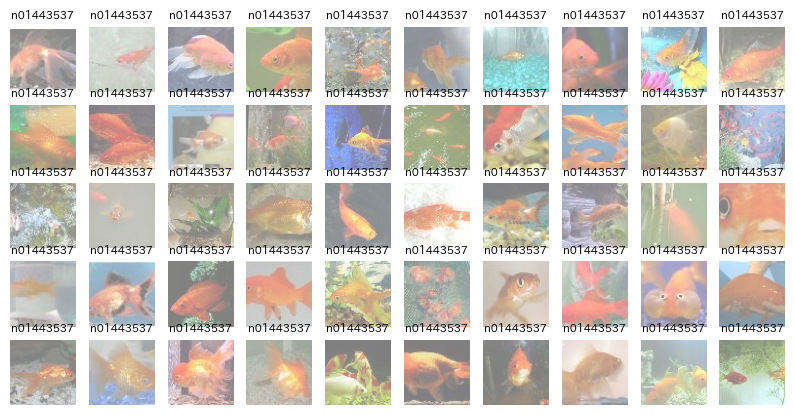

In [7]:
# Get class names (folder names) from the val_dataset
class_names = val_dataset.classes

# Get a batch of data from the val_loader
data_iter = iter(val_loader)
images, labels = next(data_iter)

# Function to convert tensor to numpy array
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Function to show 50 images with their corresponding folder names
def show_images(images, labels, class_names, num_images=50):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(10, 10, i + 1)  # Arrange images in a 10x10 grid
        imshow(images[i])
        folder_label = class_names[labels[i].item()]  # Get folder name using label
        plt.title(folder_label, fontsize=8)  # Display folder name
        plt.axis('off')
    plt.show()

# Show 50 images and their folder names
show_images(images[:50], labels[:50], class_names)

### ニューラルネットワーク多層化

#### ネットワークの定義

In [24]:
class CNN_v1(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=0)  # Input channels: 3, Output channels: 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0) # Input channels: 32, Output channels: 64
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2)  # 2x2 pooling
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(64 * 30 * 30, n_hidden)  # 64 channels, 30x30 feature map
        self.l2 = nn.Linear(n_hidden, n_output) #Fully Connected Layers: Hidden layer with 512 units, output layer with 200 units

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool
        )
        
        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3
    
    def save_checkpoint(epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

    def load_checkpoint(path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

In [25]:
class CNN_v2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=(1, 1))   # Input channels: 3, Output channels: 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=(1, 1))  # Input channels: 32, Output channels: 64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=(1, 1)) # Input channels: 64, Output channels: 128
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=(1, 1))# Input channels: 128, Output channels: 128
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=(1, 1))# Input channels: 128, Output channels: 256
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=(1, 1))# Input channels: 256, Output channels: 256
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(256 * 8 * 8, 512)  # Flattened size = 256 * 8 * 8
        self.l2 = nn.Linear(512, num_classes)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3
    
    def save_checkpoint(epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

    def load_checkpoint(path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

#### 計算グラフの表示

#### 学習

Epoch [1/25]
Train Loss: 5.2667, Train Acc: 0.0105
Val Loss: 5.1756, Val Acc: 0.0156
Epoch [2/25]
Train Loss: 5.0229, Train Acc: 0.0289
Val Loss: 4.9112, Val Acc: 0.0410
Epoch [3/25]
Train Loss: 4.7987, Train Acc: 0.0531
Val Loss: 4.7181, Val Acc: 0.0624
Epoch [4/25]
Train Loss: 4.6422, Train Acc: 0.0737
Val Loss: 4.5967, Val Acc: 0.0761
Epoch [5/25]
Train Loss: 4.5023, Train Acc: 0.0924
Val Loss: 4.4609, Val Acc: 0.0943
Epoch [6/25]
Train Loss: 4.3457, Train Acc: 0.1112
Val Loss: 4.3300, Val Acc: 0.1136
Epoch [7/25]
Train Loss: 4.1979, Train Acc: 0.1321
Val Loss: 4.2115, Val Acc: 0.1310
Epoch [8/25]
Train Loss: 4.0621, Train Acc: 0.1488
Val Loss: 4.1330, Val Acc: 0.1404
Epoch [9/25]
Train Loss: 3.9220, Train Acc: 0.1699
Val Loss: 4.0353, Val Acc: 0.1500
Epoch [10/25]
Train Loss: 3.7674, Train Acc: 0.1933
Val Loss: 3.9227, Val Acc: 0.1679
Epoch [11/25]
Train Loss: 3.6102, Train Acc: 0.2181
Val Loss: 3.8931, Val Acc: 0.1726
Epoch [12/25]
Train Loss: 3.4406, Train Acc: 0.2475
Val Loss: 3

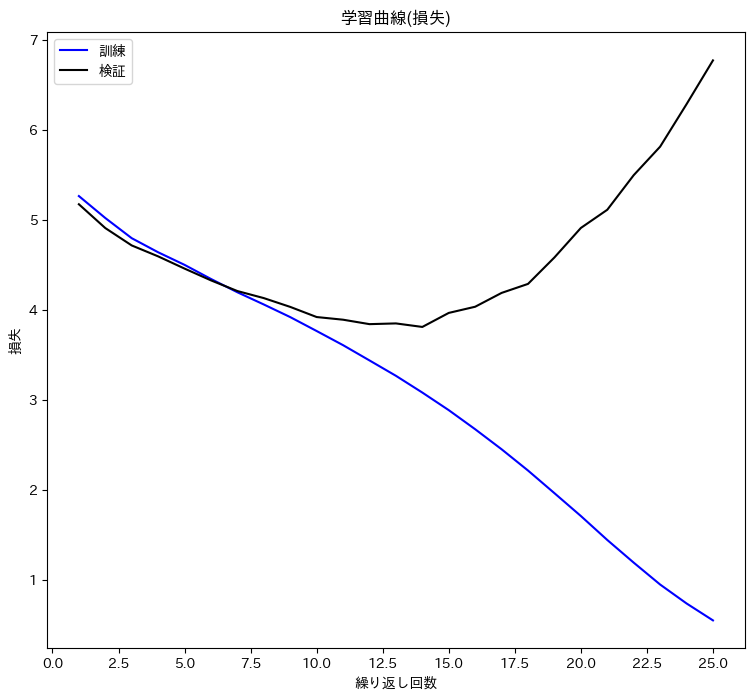

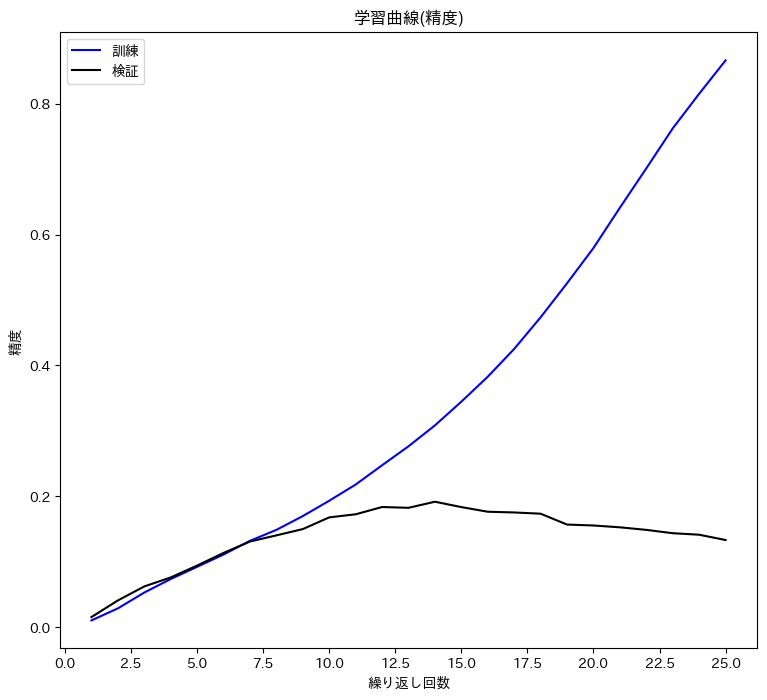

In [28]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN_v1(200, 128).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 25

# 評価結果記録用
history_cnnv1 = np.zeros((0,5))

# 学習
history_cnnv1 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history_cnnv1)

evaluate_history(history_cnnv1)

Epoch [1/25]
Train Loss: 5.2987, Train Acc: 0.0049
Val Loss: 5.2986, Val Acc: 0.0050
Epoch [2/25]
Train Loss: 5.2986, Train Acc: 0.0049
Val Loss: 5.2985, Val Acc: 0.0055
Epoch [3/25]
Train Loss: 5.2986, Train Acc: 0.0050
Val Loss: 5.2985, Val Acc: 0.0052
Epoch [4/25]
Train Loss: 5.2985, Train Acc: 0.0051
Val Loss: 5.2984, Val Acc: 0.0050
Epoch [5/25]
Train Loss: 5.2985, Train Acc: 0.0053
Val Loss: 5.2983, Val Acc: 0.0050
Epoch [6/25]
Train Loss: 5.2984, Train Acc: 0.0055
Val Loss: 5.2983, Val Acc: 0.0053
Epoch [7/25]
Train Loss: 5.2983, Train Acc: 0.0060
Val Loss: 5.2982, Val Acc: 0.0051
Epoch [8/25]
Train Loss: 5.2982, Train Acc: 0.0054
Val Loss: 5.2980, Val Acc: 0.0057
Epoch [9/25]
Train Loss: 5.2979, Train Acc: 0.0058
Val Loss: 5.2977, Val Acc: 0.0059
Epoch [10/25]
Train Loss: 5.2975, Train Acc: 0.0063
Val Loss: 5.2969, Val Acc: 0.0082
Epoch [11/25]
Train Loss: 5.2956, Train Acc: 0.0106
Val Loss: 5.2923, Val Acc: 0.0101
Epoch [12/25]
Train Loss: 5.2174, Train Acc: 0.0125
Val Loss: 5

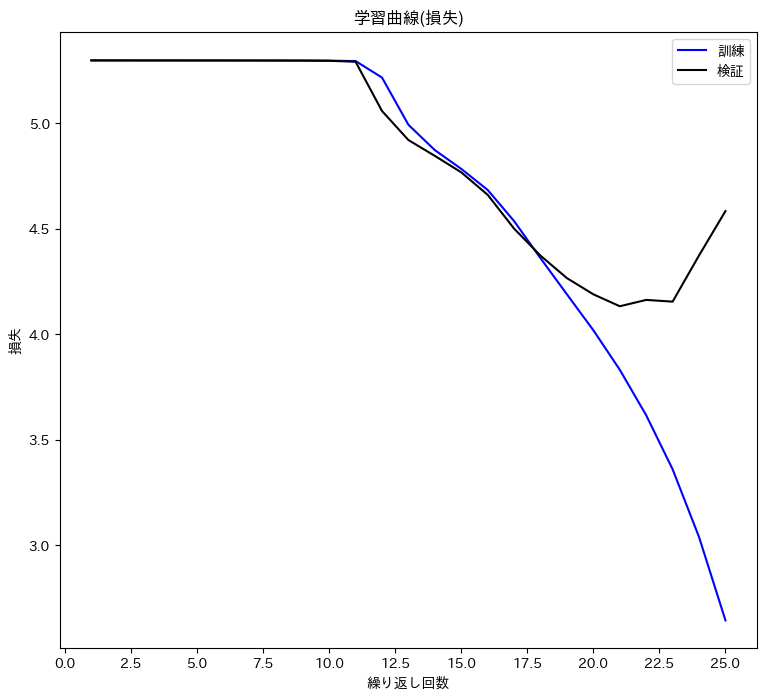

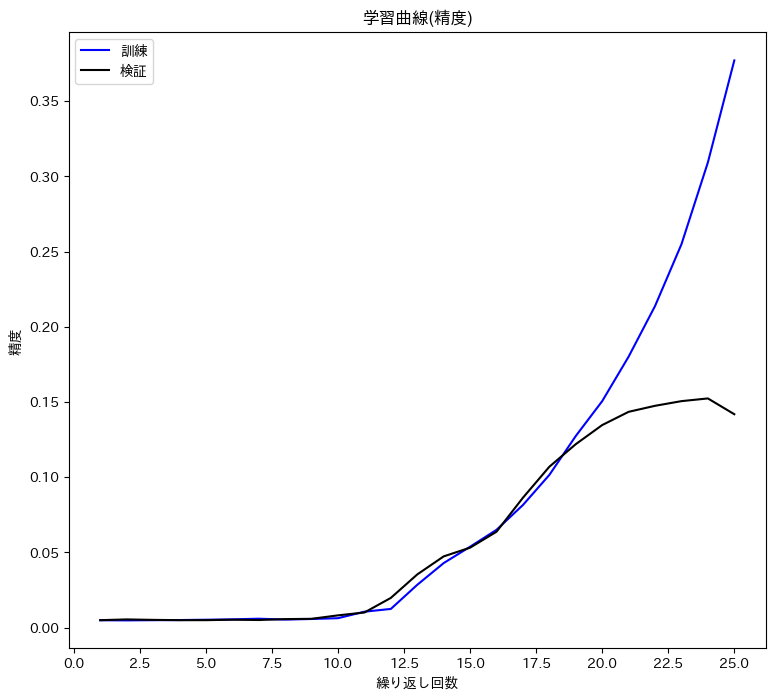

In [27]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
lr = 0.01
net = CNN_v2(200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = lr)
history = np.zeros((0, 5))

# 学習
num_epochs = 25
history = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history)

evaluate_history(history)

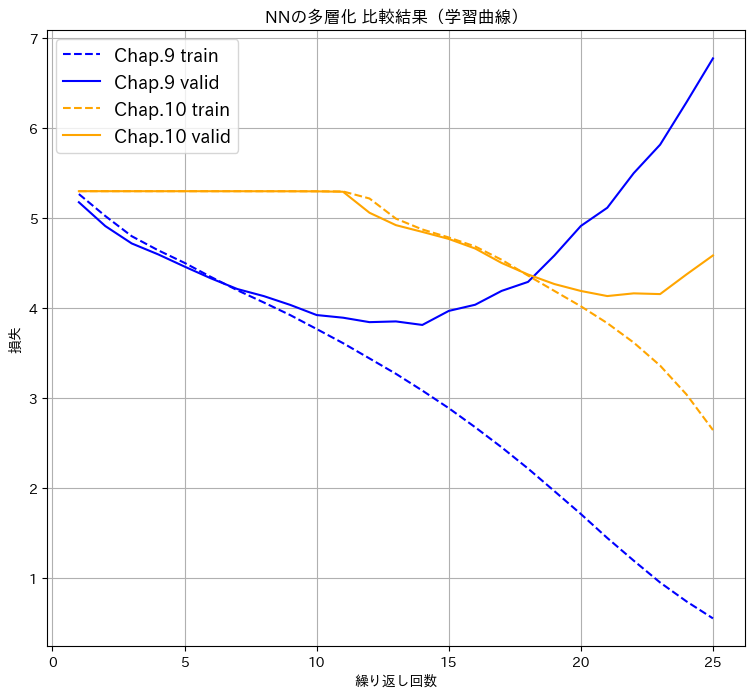

In [29]:
# 結果の比較(検証データへの精度)
plt.figure(figsize=(9,8))
plt.plot(history_cnnv1[:,0], history_cnnv1[:,1], label='Chap.9 train', c='blue', ls='dashed')
plt.plot(history_cnnv1[:,0], history_cnnv1[:,3], label='Chap.9 valid', c='blue')
plt.plot(history[:,0], history[:,1], label='Chap.10 train', c='orange', ls='dashed')
plt.plot(history[:,0], history[:,3], label='Chap.10 valid', c='orange')
plt.title('NNの多層化 比較結果（学習曲線）')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.grid()
plt.legend(fontsize = 13)
plt.show()

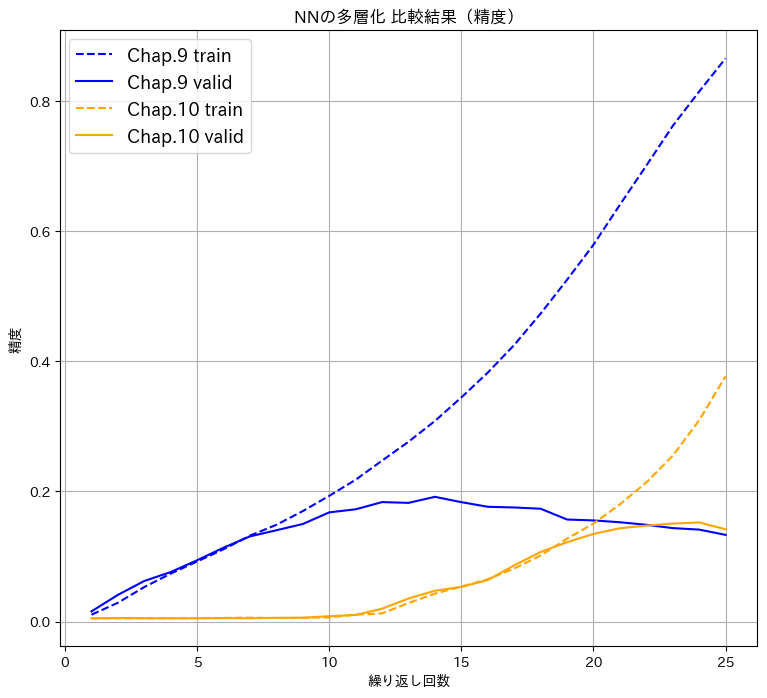

In [30]:
plt.figure(figsize=(9,8))
plt.plot(history_cnnv1[:,0], history_cnnv1[:,2], label='Chap.9 train', c='blue', ls='dashed')
plt.plot(history_cnnv1[:,0], history_cnnv1[:,4], label='Chap.9 valid', c='blue')
plt.plot(history[:,0], history[:,2], label='Chap.10 train', c='orange', ls='dashed')
plt.plot(history[:,0], history[:,4], label='Chap.10 valid', c='orange')
plt.title('NNの多層化 比較結果（精度）')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.grid()
plt.legend(fontsize = 13)
plt.show()

### 最適化関数の改善

#### momentum

Epoch [1/25]
Train Loss: 5.2990, Train Acc: 0.0044
Val Loss: 5.2983, Val Acc: 0.0053
Epoch [2/25]
Train Loss: 5.2304, Train Acc: 0.0097
Val Loss: 5.0328, Val Acc: 0.0217
Epoch [3/25]
Train Loss: 4.8509, Train Acc: 0.0415
Val Loss: 4.6254, Val Acc: 0.0639
Epoch [4/25]
Train Loss: 4.3392, Train Acc: 0.1009
Val Loss: 4.0800, Val Acc: 0.1340
Epoch [5/25]
Train Loss: 3.8036, Train Acc: 0.1773
Val Loss: 3.7029, Val Acc: 0.1879
Epoch [6/25]
Train Loss: 3.3558, Train Acc: 0.2485
Val Loss: 3.5040, Val Acc: 0.2263
Epoch [7/25]
Train Loss: 2.9028, Train Acc: 0.3268
Val Loss: 3.4657, Val Acc: 0.2409
Epoch [8/25]
Train Loss: 2.3473, Train Acc: 0.4300
Val Loss: 3.5986, Val Acc: 0.2434
Epoch [9/25]
Train Loss: 1.6418, Train Acc: 0.5769
Val Loss: 4.1416, Val Acc: 0.2171
Epoch [10/25]
Train Loss: 0.9222, Train Acc: 0.7438
Val Loss: 5.3730, Val Acc: 0.2080
Epoch [11/25]
Train Loss: 0.5509, Train Acc: 0.8408
Val Loss: 6.1723, Val Acc: 0.2011
Epoch [12/25]
Train Loss: 0.3703, Train Acc: 0.8907
Val Loss: 6

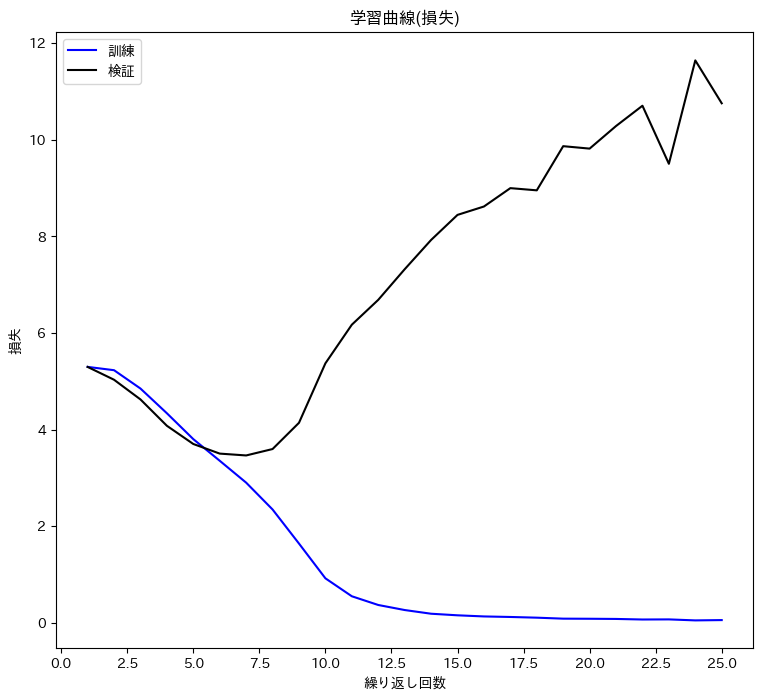

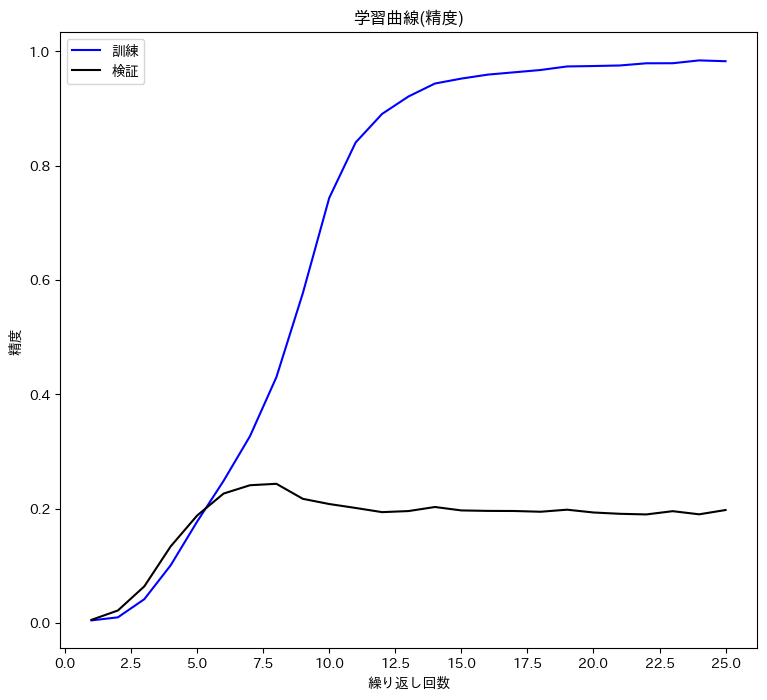

In [31]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
lr = 0.01
net = CNN_v2(200).to(device)
criterion = nn.CrossEntropyLoss()

# 最適化関数にmomentumを指定
optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)
history2 = np.zeros((0, 5))

# 学習
num_epochs = 25
history2 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history2)

evaluate_history(history2)

#### Adam

Epoch [1/25]
Train Loss: 4.9105, Train Acc: 0.0369
Val Loss: 4.5413, Val Acc: 0.0800
Epoch [2/25]
Train Loss: 4.2413, Train Acc: 0.1182
Val Loss: 4.0831, Val Acc: 0.1398
Epoch [3/25]
Train Loss: 3.8414, Train Acc: 0.1761
Val Loss: 3.8302, Val Acc: 0.1767
Epoch [4/25]
Train Loss: 3.5731, Train Acc: 0.2179
Val Loss: 3.6821, Val Acc: 0.2025
Epoch [5/25]
Train Loss: 3.3327, Train Acc: 0.2587
Val Loss: 3.6087, Val Acc: 0.2139
Epoch [6/25]
Train Loss: 3.0990, Train Acc: 0.2993
Val Loss: 3.5530, Val Acc: 0.2285
Epoch [7/25]
Train Loss: 2.8442, Train Acc: 0.3447
Val Loss: 3.5234, Val Acc: 0.2425
Epoch [8/25]
Train Loss: 2.5710, Train Acc: 0.3951
Val Loss: 3.5940, Val Acc: 0.2426
Epoch [9/25]
Train Loss: 2.2681, Train Acc: 0.4555
Val Loss: 3.7749, Val Acc: 0.2380
Epoch [10/25]
Train Loss: 1.9352, Train Acc: 0.5253
Val Loss: 3.9516, Val Acc: 0.2376
Epoch [11/25]
Train Loss: 1.5836, Train Acc: 0.6020
Val Loss: 4.3474, Val Acc: 0.2238
Epoch [12/25]
Train Loss: 1.2215, Train Acc: 0.6860
Val Loss: 4

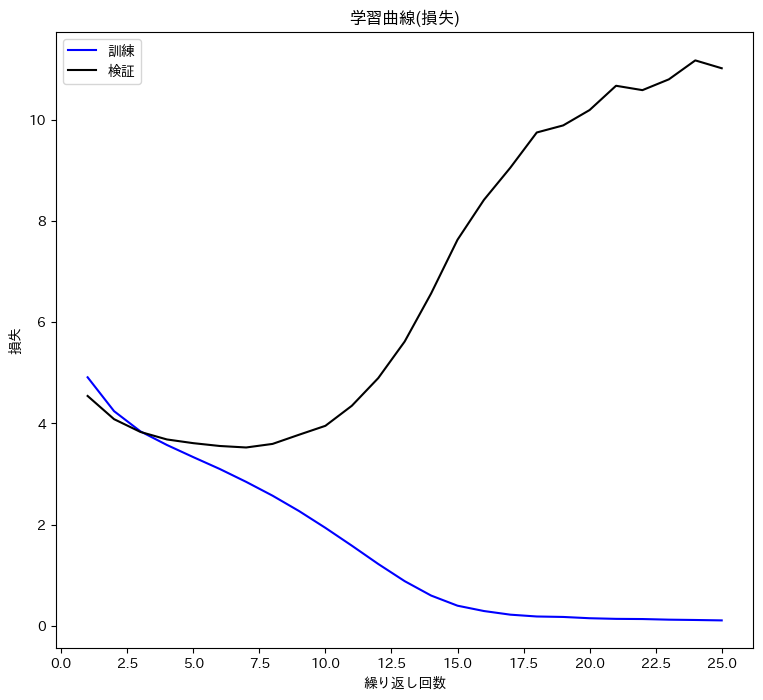

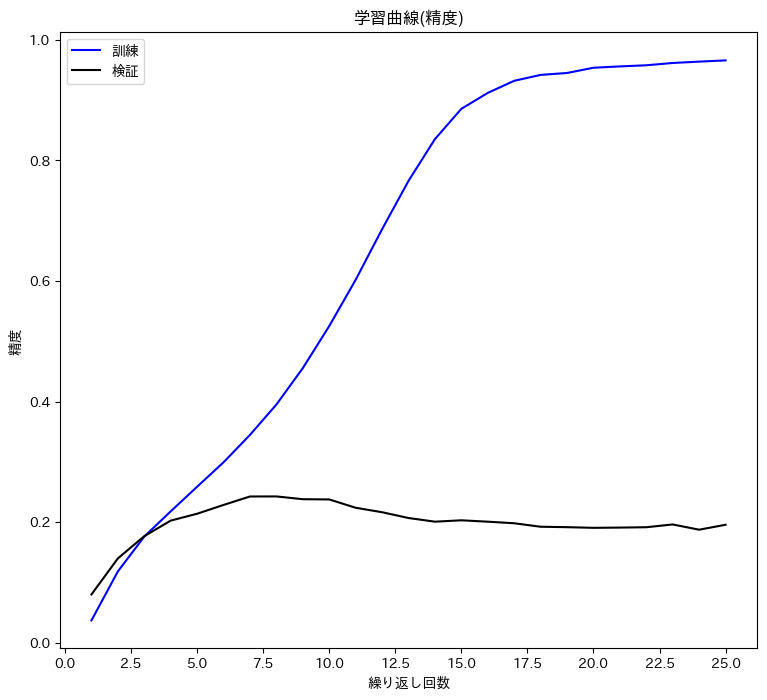

In [35]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v2(200).to(device)
criterion = nn.CrossEntropyLoss()

# 最適化関数にAdamを指定
optimizer = optim.Adam(net.parameters(), lr = 0.0001)
history3 = np.zeros((0, 5))

# 学習
num_epochs = 25
history3 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history3)

evaluate_history(history3)

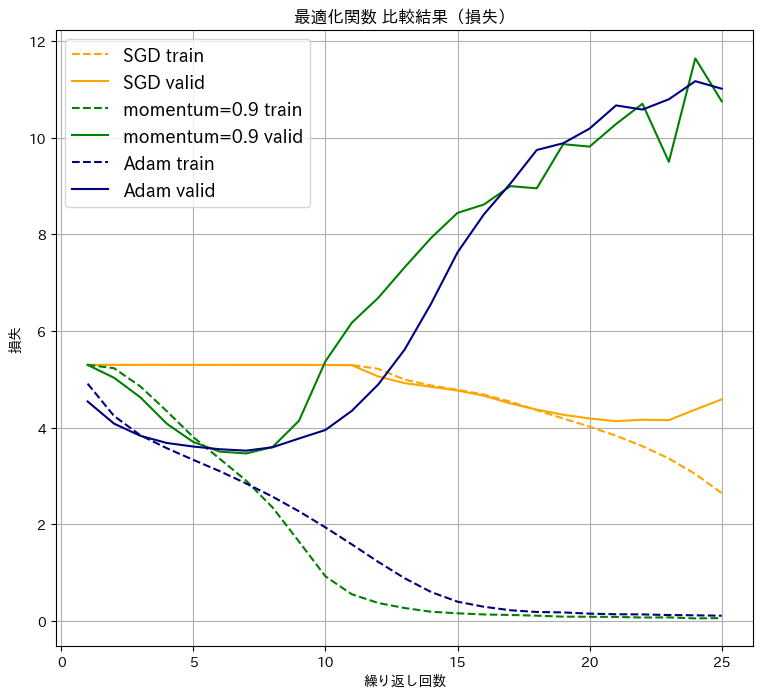

In [36]:
# 結果の比較(学習データへの精度)
plt.figure(figsize=(9,8))
plt.plot(history[:,0], history[:,1], label='SGD train', c='orange', ls='dashed')
plt.plot(history[:,0], history[:,3], label='SGD valid', c='orange')
plt.plot(history2[:,0], history2[:,1], label='momentum=0.9 train', c='green', ls='dashed')
plt.plot(history2[:,0], history2[:,3], label='momentum=0.9 valid', c='green')
plt.plot(history3[:,0], history3[:,1], label='Adam train', c='navy', ls='dashed')
plt.plot(history3[:,0], history3[:,3], label='Adam valid', c='navy')
plt.title('最適化関数 比較結果（損失）')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.grid()
plt.legend(fontsize = 13)
plt.show()

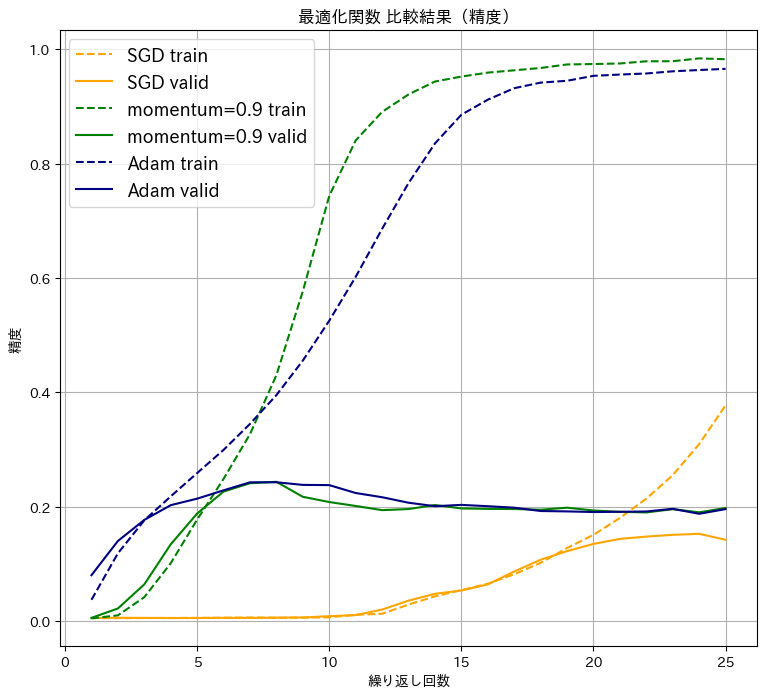

In [37]:
# 結果の比較(検証データへの精度)
plt.figure(figsize=(9,8))
plt.plot(history[:,0], history[:,2], label='SGD train', c='orange', ls='dashed')
plt.plot(history[:,0], history[:,4], label='SGD valid', c='orange')
plt.plot(history2[:,0], history2[:,2], label='momentum=0.9 train', c='green', ls='dashed')
plt.plot(history2[:,0], history2[:,4], label='momentum=0.9 valid', c='green')
plt.plot(history3[:,0], history3[:,2], label='Adam train', c='navy', ls='dashed')
plt.plot(history3[:,0], history3[:,4], label='Adam valid', c='navy')
plt.title('最適化関数 比較結果（精度）')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.grid()
plt.legend(fontsize = 13)
plt.show()

### 過学習対策

#### ドロップアウト

In [14]:
class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))  # 64x64x3 → 64x64x32
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))  # 64x64x32 → 64x64x32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))  # 32x32x32 → 32x32x64
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))  # 32x32x64 → 32x32x64
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1)) # 16x16x64 → 16x16x128
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1)) # 16x16x128 → 16x16x128
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(8192, 128)  # 8x8x128 → 8192
        self.l2 = nn.Linear(128, 200)  # 128 → 200
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3
    
    def save_checkpoint(epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

    def load_checkpoint(path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/50], loss: 5.20045 acc: 0.01207 val_loss: 5.04201, val_acc: 0.02370


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/50], loss: 4.99884 acc: 0.02571 val_loss: 4.83825, val_acc: 0.04160


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/50], loss: 4.81248 acc: 0.04321 val_loss: 4.64927, val_acc: 0.06460


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/50], loss: 4.62038 acc: 0.06114 val_loss: 4.40045, val_acc: 0.09560


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/50], loss: 4.46165 acc: 0.07856 val_loss: 4.22192, val_acc: 0.11690


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [6/50], loss: 4.33559 acc: 0.09368 val_loss: 4.07650, val_acc: 0.13410


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [7/50], loss: 4.23732 acc: 0.10594 val_loss: 4.00916, val_acc: 0.14880


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [8/50], loss: 4.14909 acc: 0.11625 val_loss: 3.92363, val_acc: 0.15680


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [9/50], loss: 4.07607 acc: 0.12614 val_loss: 3.83236, val_acc: 0.16890


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/50], loss: 4.00391 acc: 0.13568 val_loss: 3.80706, val_acc: 0.17130


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [11/50], loss: 3.94349 acc: 0.14421 val_loss: 3.72088, val_acc: 0.18920


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [12/50], loss: 3.90057 acc: 0.15140 val_loss: 3.65813, val_acc: 0.19550


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [13/50], loss: 3.85420 acc: 0.15894 val_loss: 3.66313, val_acc: 0.19960


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [14/50], loss: 3.80880 acc: 0.16523 val_loss: 3.59943, val_acc: 0.20650


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [15/50], loss: 3.76891 acc: 0.17104 val_loss: 3.54756, val_acc: 0.21880


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [16/50], loss: 3.72484 acc: 0.17730 val_loss: 3.49809, val_acc: 0.22010


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [17/50], loss: 3.69418 acc: 0.18172 val_loss: 3.46154, val_acc: 0.22900


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [18/50], loss: 3.66195 acc: 0.18553 val_loss: 3.46618, val_acc: 0.22900


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [19/50], loss: 3.63002 acc: 0.19192 val_loss: 3.42392, val_acc: 0.24350


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [20/50], loss: 3.60063 acc: 0.19642 val_loss: 3.39735, val_acc: 0.24090


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [21/50], loss: 3.57684 acc: 0.19970 val_loss: 3.41077, val_acc: 0.24260


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [22/50], loss: 3.54423 acc: 0.20428 val_loss: 3.38374, val_acc: 0.24530


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [23/50], loss: 3.51945 acc: 0.20827 val_loss: 3.32612, val_acc: 0.25390


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [24/50], loss: 3.50125 acc: 0.21081 val_loss: 3.33143, val_acc: 0.25160


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [25/50], loss: 3.47933 acc: 0.21423 val_loss: 3.30672, val_acc: 0.25840


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [26/50], loss: 3.45474 acc: 0.21840 val_loss: 3.33339, val_acc: 0.25290


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [27/50], loss: 3.43333 acc: 0.22164 val_loss: 3.26962, val_acc: 0.25970


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [28/50], loss: 3.40923 acc: 0.22595 val_loss: 3.24396, val_acc: 0.26220


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [29/50], loss: 3.38622 acc: 0.22946 val_loss: 3.22269, val_acc: 0.27240


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [30/50], loss: 3.36893 acc: 0.23167 val_loss: 3.25536, val_acc: 0.26450


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [31/50], loss: 3.34723 acc: 0.23432 val_loss: 3.20641, val_acc: 0.27590


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [32/50], loss: 3.33123 acc: 0.23871 val_loss: 3.19869, val_acc: 0.27330


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [33/50], loss: 3.30608 acc: 0.24137 val_loss: 3.21731, val_acc: 0.27240


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [34/50], loss: 3.29186 acc: 0.24498 val_loss: 3.17544, val_acc: 0.27880


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [35/50], loss: 3.28000 acc: 0.24739 val_loss: 3.17055, val_acc: 0.28110


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [36/50], loss: 3.25149 acc: 0.25036 val_loss: 3.17800, val_acc: 0.28170


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [37/50], loss: 3.24184 acc: 0.25183 val_loss: 3.13547, val_acc: 0.28590


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [38/50], loss: 3.22631 acc: 0.25372 val_loss: 3.11297, val_acc: 0.29460


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [39/50], loss: 3.20442 acc: 0.25821 val_loss: 3.11312, val_acc: 0.28690


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [40/50], loss: 3.18813 acc: 0.26125 val_loss: 3.10666, val_acc: 0.29120


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [41/50], loss: 3.17135 acc: 0.26387 val_loss: 3.07985, val_acc: 0.29560


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [42/50], loss: 3.16023 acc: 0.26604 val_loss: 3.08038, val_acc: 0.29300


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [43/50], loss: 3.14353 acc: 0.26784 val_loss: 3.09704, val_acc: 0.29080


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [44/50], loss: 3.13189 acc: 0.27064 val_loss: 3.06857, val_acc: 0.29560


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [45/50], loss: 3.11914 acc: 0.27307 val_loss: 3.06850, val_acc: 0.29870


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [46/50], loss: 3.10861 acc: 0.27279 val_loss: 3.10368, val_acc: 0.29010


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [47/50], loss: 3.09559 acc: 0.27454 val_loss: 3.04397, val_acc: 0.30110


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [48/50], loss: 3.07913 acc: 0.27678 val_loss: 3.05052, val_acc: 0.30210


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [49/50], loss: 3.06451 acc: 0.28113 val_loss: 3.05012, val_acc: 0.29960


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [50/50], loss: 3.05273 acc: 0.28278 val_loss: 3.05127, val_acc: 0.30360
初期状態: 損失: 5.04201 精度: 0.02370
最終状態: 損失: 3.05127 精度: 0.30360


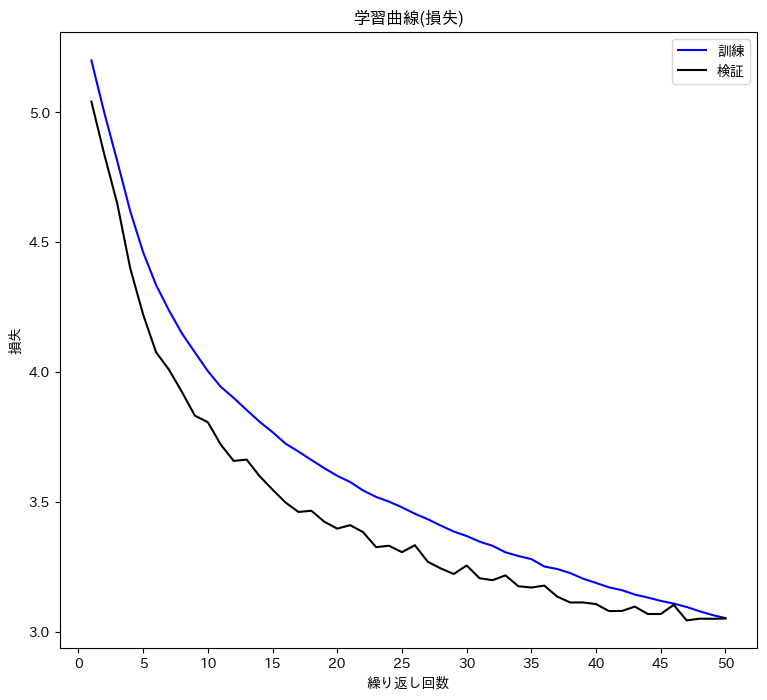

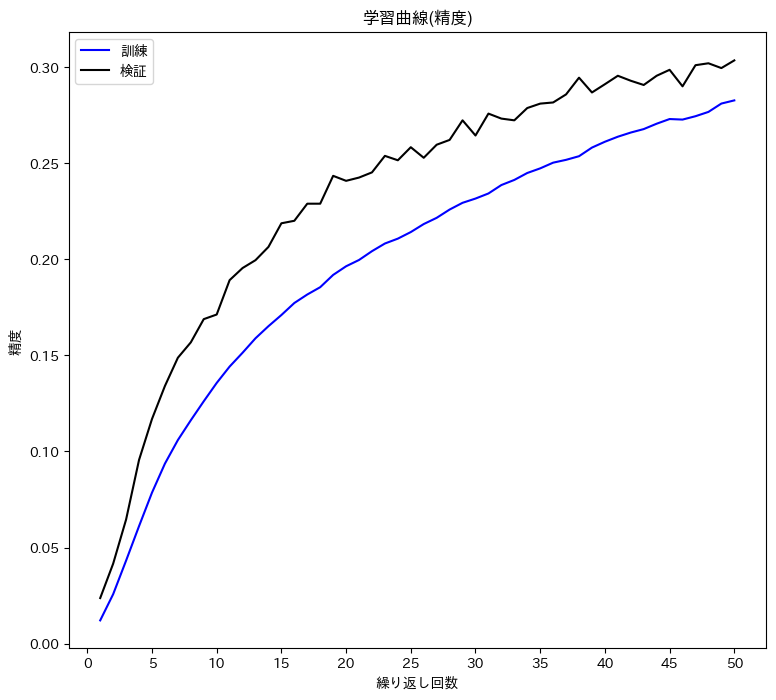

In [15]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v3(200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
history4 = np.zeros((0, 5))

num_epochs = 50
history4 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history4)

evaluate_history(history4)

#### Batch Normalization

In [16]:
class CNN_v4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))  # 64x64x3 → 64x64x32
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))  # 64x64x32 → 64x64x32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))  # 32x32x32 → 32x32x64
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))  # 32x32x64 → 32x32x64
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1)) # 16x16x64 → 16x16x128
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1)) # 16x16x128 → 16x16x128
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(8192, 128)  # 8x8x128 → 8192
        self.l2 = nn.Linear(128, 200)  # 128 → 200
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3
    
    def save_checkpoint(epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

    def load_checkpoint(path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/50], loss: 5.28417 acc: 0.00721 val_loss: 5.23146, val_acc: 0.01340


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/50], loss: 5.19846 acc: 0.01259 val_loss: 5.08282, val_acc: 0.01620


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/50], loss: 5.05888 acc: 0.01974 val_loss: 4.93188, val_acc: 0.02660


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/50], loss: 4.91001 acc: 0.02608 val_loss: 4.75196, val_acc: 0.04070


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/50], loss: 4.77847 acc: 0.03236 val_loss: 4.59709, val_acc: 0.05900


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [6/50], loss: 4.66616 acc: 0.04109 val_loss: 4.45834, val_acc: 0.06950


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [7/50], loss: 4.57558 acc: 0.04847 val_loss: 4.34413, val_acc: 0.08230


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [8/50], loss: 4.49920 acc: 0.05409 val_loss: 4.19655, val_acc: 0.10330


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [9/50], loss: 4.44941 acc: 0.05985 val_loss: 4.12670, val_acc: 0.11210


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/50], loss: 4.40720 acc: 0.06341 val_loss: 4.10664, val_acc: 0.11170


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [11/50], loss: 4.37390 acc: 0.06673 val_loss: 4.10619, val_acc: 0.11420


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [12/50], loss: 4.35367 acc: 0.06824 val_loss: 4.03031, val_acc: 0.12620


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [13/50], loss: 4.32665 acc: 0.07062 val_loss: 4.03307, val_acc: 0.12660


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [14/50], loss: 4.30919 acc: 0.07178 val_loss: 3.97963, val_acc: 0.12890


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [15/50], loss: 4.29460 acc: 0.07371 val_loss: 3.97067, val_acc: 0.14030


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [16/50], loss: 4.28016 acc: 0.07436 val_loss: 3.90570, val_acc: 0.14630


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [17/50], loss: 4.25989 acc: 0.07546 val_loss: 4.00628, val_acc: 0.13120


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [18/50], loss: 4.25549 acc: 0.07616 val_loss: 3.91756, val_acc: 0.13930


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [19/50], loss: 4.24373 acc: 0.07651 val_loss: 3.80835, val_acc: 0.16120


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [20/50], loss: 4.22711 acc: 0.07918 val_loss: 3.81440, val_acc: 0.15730


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [21/50], loss: 4.21329 acc: 0.08007 val_loss: 3.85714, val_acc: 0.15440


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [22/50], loss: 4.20815 acc: 0.08044 val_loss: 3.82080, val_acc: 0.15390


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [23/50], loss: 4.19536 acc: 0.08093 val_loss: 3.77410, val_acc: 0.16570


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [24/50], loss: 4.19113 acc: 0.08188 val_loss: 3.75239, val_acc: 0.17470


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [25/50], loss: 4.17917 acc: 0.08348 val_loss: 3.76487, val_acc: 0.17080


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [26/50], loss: 4.17528 acc: 0.08218 val_loss: 3.77562, val_acc: 0.16980


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [27/50], loss: 4.17350 acc: 0.08400 val_loss: 3.74920, val_acc: 0.17000


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [28/50], loss: 4.15684 acc: 0.08477 val_loss: 3.79890, val_acc: 0.16330


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [29/50], loss: 4.15274 acc: 0.08497 val_loss: 3.72436, val_acc: 0.17230


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [30/50], loss: 4.14752 acc: 0.08501 val_loss: 3.73648, val_acc: 0.17170


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [31/50], loss: 4.13670 acc: 0.08757 val_loss: 3.67289, val_acc: 0.18060


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [32/50], loss: 4.13106 acc: 0.08784 val_loss: 3.74924, val_acc: 0.17380


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [33/50], loss: 4.13052 acc: 0.08672 val_loss: 3.73167, val_acc: 0.17800


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [34/50], loss: 4.12220 acc: 0.08859 val_loss: 3.69139, val_acc: 0.17900


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [35/50], loss: 4.11599 acc: 0.08930 val_loss: 3.66921, val_acc: 0.18350


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [36/50], loss: 4.11182 acc: 0.08914 val_loss: 3.64807, val_acc: 0.18610


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [37/50], loss: 4.10746 acc: 0.09008 val_loss: 3.68175, val_acc: 0.18140


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [38/50], loss: 4.10213 acc: 0.09221 val_loss: 3.64512, val_acc: 0.19050


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [39/50], loss: 4.09200 acc: 0.09053 val_loss: 3.66764, val_acc: 0.18060


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [40/50], loss: 4.08830 acc: 0.09142 val_loss: 3.64227, val_acc: 0.18630


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [41/50], loss: 4.08074 acc: 0.09228 val_loss: 3.63728, val_acc: 0.18410


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [42/50], loss: 4.06820 acc: 0.09337 val_loss: 3.65751, val_acc: 0.19080


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [43/50], loss: 4.08023 acc: 0.09376 val_loss: 3.64819, val_acc: 0.18280


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [44/50], loss: 4.07387 acc: 0.09373 val_loss: 3.64577, val_acc: 0.19360


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [45/50], loss: 4.06689 acc: 0.09503 val_loss: 3.66700, val_acc: 0.17930


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [46/50], loss: 4.06246 acc: 0.09363 val_loss: 3.62205, val_acc: 0.19010


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [47/50], loss: 4.05368 acc: 0.09456 val_loss: 3.62222, val_acc: 0.19340


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [48/50], loss: 4.05856 acc: 0.09529 val_loss: 3.65997, val_acc: 0.18410


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [49/50], loss: 4.04952 acc: 0.09565 val_loss: 3.59166, val_acc: 0.19340


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [50/50], loss: 4.03581 acc: 0.09636 val_loss: 3.65371, val_acc: 0.18420
初期状態: 損失: 5.23146 精度: 0.01340
最終状態: 損失: 3.65371 精度: 0.18420


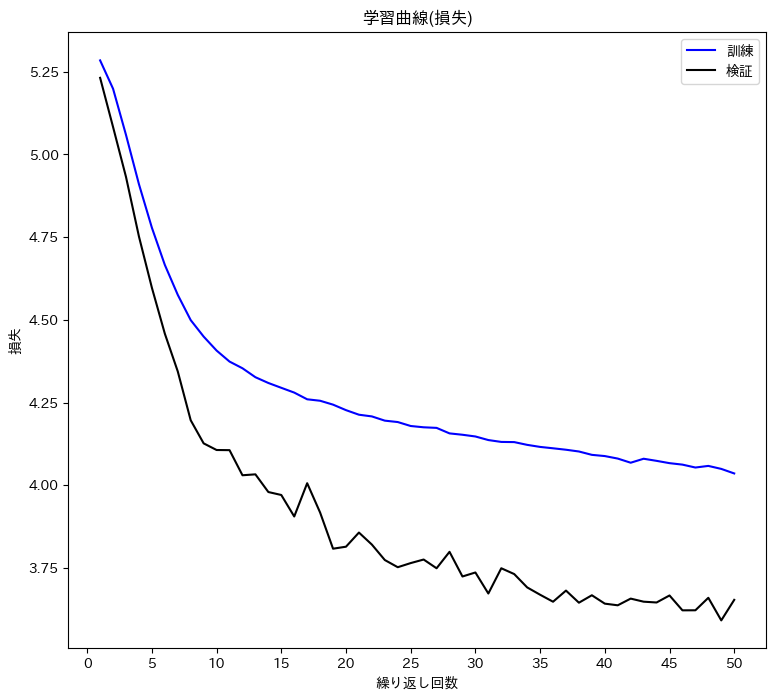

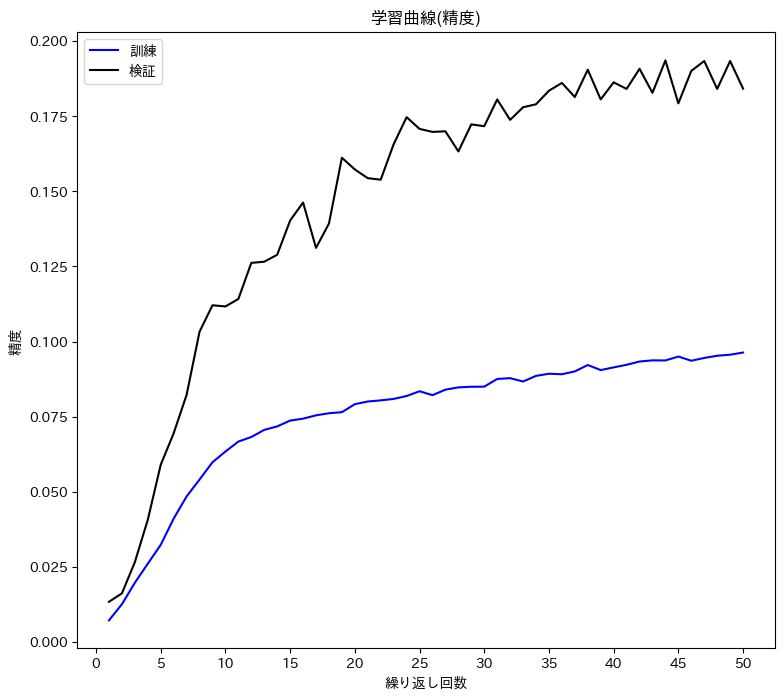

In [24]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v4(200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
history5 = np.zeros((0, 5))

num_epochs = 50
history5 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history5)

evaluate_history(history5)

#### Data Augmentation

In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define the transform for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# Define DataLoader
batch_size = 100
train_loader2 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/100], loss: 5.28417 acc: 0.00721 val_loss: 5.23146, val_acc: 0.01340


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/100], loss: 5.19846 acc: 0.01259 val_loss: 5.08282, val_acc: 0.01620


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/100], loss: 5.05888 acc: 0.01974 val_loss: 4.93188, val_acc: 0.02660


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/100], loss: 4.91001 acc: 0.02608 val_loss: 4.75196, val_acc: 0.04070


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/100], loss: 4.77847 acc: 0.03236 val_loss: 4.59709, val_acc: 0.05900


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [6/100], loss: 4.66616 acc: 0.04109 val_loss: 4.45834, val_acc: 0.06950


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [7/100], loss: 4.57558 acc: 0.04847 val_loss: 4.34413, val_acc: 0.08230


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [8/100], loss: 4.49920 acc: 0.05409 val_loss: 4.19655, val_acc: 0.10330


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [9/100], loss: 4.44941 acc: 0.05985 val_loss: 4.12670, val_acc: 0.11210


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/100], loss: 4.40720 acc: 0.06341 val_loss: 4.10664, val_acc: 0.11170


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [11/100], loss: 4.37390 acc: 0.06673 val_loss: 4.10619, val_acc: 0.11420


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [12/100], loss: 4.35367 acc: 0.06824 val_loss: 4.03031, val_acc: 0.12620


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [13/100], loss: 4.32665 acc: 0.07062 val_loss: 4.03307, val_acc: 0.12660


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [14/100], loss: 4.30919 acc: 0.07178 val_loss: 3.97963, val_acc: 0.12890


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [15/100], loss: 4.29460 acc: 0.07371 val_loss: 3.97067, val_acc: 0.14030


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [16/100], loss: 4.28016 acc: 0.07436 val_loss: 3.90570, val_acc: 0.14630


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [17/100], loss: 4.25989 acc: 0.07546 val_loss: 4.00628, val_acc: 0.13120


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [18/100], loss: 4.25549 acc: 0.07616 val_loss: 3.91756, val_acc: 0.13930


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [19/100], loss: 4.24373 acc: 0.07651 val_loss: 3.80835, val_acc: 0.16120


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [20/100], loss: 4.22711 acc: 0.07918 val_loss: 3.81440, val_acc: 0.15730


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [21/100], loss: 4.21329 acc: 0.08007 val_loss: 3.85714, val_acc: 0.15440


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [22/100], loss: 4.20815 acc: 0.08044 val_loss: 3.82080, val_acc: 0.15390


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [23/100], loss: 4.19536 acc: 0.08093 val_loss: 3.77410, val_acc: 0.16570


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [24/100], loss: 4.19113 acc: 0.08188 val_loss: 3.75239, val_acc: 0.17470


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [25/100], loss: 4.17917 acc: 0.08348 val_loss: 3.76487, val_acc: 0.17080


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [26/100], loss: 4.17528 acc: 0.08218 val_loss: 3.77562, val_acc: 0.16980


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [27/100], loss: 4.17350 acc: 0.08400 val_loss: 3.74920, val_acc: 0.17000


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [28/100], loss: 4.15684 acc: 0.08477 val_loss: 3.79890, val_acc: 0.16330


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [29/100], loss: 4.15274 acc: 0.08497 val_loss: 3.72436, val_acc: 0.17230


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [30/100], loss: 4.14752 acc: 0.08501 val_loss: 3.73648, val_acc: 0.17170


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [31/100], loss: 4.13670 acc: 0.08757 val_loss: 3.67289, val_acc: 0.18060


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [32/100], loss: 4.13106 acc: 0.08784 val_loss: 3.74924, val_acc: 0.17380


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [33/100], loss: 4.13052 acc: 0.08672 val_loss: 3.73167, val_acc: 0.17800


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [34/100], loss: 4.12220 acc: 0.08859 val_loss: 3.69139, val_acc: 0.17900


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [35/100], loss: 4.11599 acc: 0.08930 val_loss: 3.66921, val_acc: 0.18350


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [36/100], loss: 4.11182 acc: 0.08914 val_loss: 3.64807, val_acc: 0.18610


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [37/100], loss: 4.10746 acc: 0.09008 val_loss: 3.68175, val_acc: 0.18140


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [38/100], loss: 4.10213 acc: 0.09221 val_loss: 3.64512, val_acc: 0.19050


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [39/100], loss: 4.09200 acc: 0.09053 val_loss: 3.66764, val_acc: 0.18060


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [40/100], loss: 4.08830 acc: 0.09142 val_loss: 3.64227, val_acc: 0.18630


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [41/100], loss: 4.08074 acc: 0.09228 val_loss: 3.63728, val_acc: 0.18410


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [42/100], loss: 4.06820 acc: 0.09337 val_loss: 3.65751, val_acc: 0.19080


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [43/100], loss: 4.08023 acc: 0.09376 val_loss: 3.64819, val_acc: 0.18280


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [44/100], loss: 4.07387 acc: 0.09373 val_loss: 3.64577, val_acc: 0.19360


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [45/100], loss: 4.06689 acc: 0.09503 val_loss: 3.66700, val_acc: 0.17930


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [46/100], loss: 4.06246 acc: 0.09363 val_loss: 3.62205, val_acc: 0.19010


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [47/100], loss: 4.05368 acc: 0.09456 val_loss: 3.62222, val_acc: 0.19340


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [48/100], loss: 4.05856 acc: 0.09529 val_loss: 3.65997, val_acc: 0.18410


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [49/100], loss: 4.04952 acc: 0.09565 val_loss: 3.59166, val_acc: 0.19340


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [50/100], loss: 4.03581 acc: 0.09636 val_loss: 3.65371, val_acc: 0.18420


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [51/100], loss: 4.03928 acc: 0.09715 val_loss: 3.56791, val_acc: 0.19320


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [52/100], loss: 4.03688 acc: 0.09751 val_loss: 3.55839, val_acc: 0.19650


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [53/100], loss: 4.03351 acc: 0.09677 val_loss: 3.66950, val_acc: 0.18440


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [54/100], loss: 4.03396 acc: 0.09718 val_loss: 3.56479, val_acc: 0.19500


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [55/100], loss: 4.03079 acc: 0.09880 val_loss: 3.63184, val_acc: 0.19210


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [56/100], loss: 4.02197 acc: 0.09847 val_loss: 3.56305, val_acc: 0.20120


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [57/100], loss: 4.01667 acc: 0.09991 val_loss: 3.56911, val_acc: 0.19690


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [58/100], loss: 4.01549 acc: 0.10147 val_loss: 3.60980, val_acc: 0.19050


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [59/100], loss: 4.01540 acc: 0.09937 val_loss: 3.64028, val_acc: 0.19080


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [60/100], loss: 4.00895 acc: 0.09964 val_loss: 3.56279, val_acc: 0.19440


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [61/100], loss: 4.00841 acc: 0.10030 val_loss: 3.56346, val_acc: 0.19900


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [62/100], loss: 3.99894 acc: 0.10059 val_loss: 3.54752, val_acc: 0.19910


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [63/100], loss: 3.98677 acc: 0.10277 val_loss: 3.52151, val_acc: 0.21080


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [64/100], loss: 3.97672 acc: 0.10313 val_loss: 3.50493, val_acc: 0.20460


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [65/100], loss: 3.97423 acc: 0.10578 val_loss: 3.51144, val_acc: 0.20400


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [66/100], loss: 3.96085 acc: 0.10709 val_loss: 3.48277, val_acc: 0.21030


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [67/100], loss: 3.96168 acc: 0.10751 val_loss: 3.51503, val_acc: 0.20660


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [68/100], loss: 3.95345 acc: 0.10828 val_loss: 3.49274, val_acc: 0.20500


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [69/100], loss: 3.94698 acc: 0.10908 val_loss: 3.48792, val_acc: 0.21220


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [70/100], loss: 3.94558 acc: 0.10834 val_loss: 3.49522, val_acc: 0.20630


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [71/100], loss: 3.93587 acc: 0.11058 val_loss: 3.51125, val_acc: 0.20820


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [72/100], loss: 3.93792 acc: 0.10992 val_loss: 3.47678, val_acc: 0.21380


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [73/100], loss: 3.93209 acc: 0.10958 val_loss: 3.45396, val_acc: 0.22010


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [74/100], loss: 3.92460 acc: 0.11090 val_loss: 3.51201, val_acc: 0.21150


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [75/100], loss: 3.92622 acc: 0.11042 val_loss: 3.52794, val_acc: 0.20870


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [76/100], loss: 3.92343 acc: 0.11150 val_loss: 3.52352, val_acc: 0.20910


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [77/100], loss: 3.91649 acc: 0.11277 val_loss: 3.50640, val_acc: 0.20850


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [78/100], loss: 3.92141 acc: 0.11317 val_loss: 3.48359, val_acc: 0.21200


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [79/100], loss: 3.91294 acc: 0.11220 val_loss: 3.49561, val_acc: 0.20610


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [80/100], loss: 3.91413 acc: 0.11266 val_loss: 3.49066, val_acc: 0.21740


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [81/100], loss: 3.90417 acc: 0.11327 val_loss: 3.47356, val_acc: 0.21540


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [82/100], loss: 3.90384 acc: 0.11376 val_loss: 3.46240, val_acc: 0.21690


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [83/100], loss: 3.90205 acc: 0.11363 val_loss: 3.46540, val_acc: 0.21930


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [84/100], loss: 3.90261 acc: 0.11425 val_loss: 3.43691, val_acc: 0.22050


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [85/100], loss: 3.89777 acc: 0.11255 val_loss: 3.42569, val_acc: 0.22020


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [86/100], loss: 3.89472 acc: 0.11738 val_loss: 3.45468, val_acc: 0.21310


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [87/100], loss: 3.89231 acc: 0.11508 val_loss: 3.43936, val_acc: 0.22380


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [88/100], loss: 3.88494 acc: 0.11561 val_loss: 3.41466, val_acc: 0.22510


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [89/100], loss: 3.89005 acc: 0.11485 val_loss: 3.45086, val_acc: 0.21890


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [90/100], loss: 3.88636 acc: 0.11446 val_loss: 3.46106, val_acc: 0.21890


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [91/100], loss: 3.87639 acc: 0.11626 val_loss: 3.44752, val_acc: 0.22210


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [92/100], loss: 3.87099 acc: 0.11820 val_loss: 3.46298, val_acc: 0.21330


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [93/100], loss: 3.87173 acc: 0.11774 val_loss: 3.44612, val_acc: 0.22150


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [94/100], loss: 3.86322 acc: 0.11850 val_loss: 3.41958, val_acc: 0.22400


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [95/100], loss: 3.84977 acc: 0.12052 val_loss: 3.44632, val_acc: 0.22090


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [96/100], loss: 3.84133 acc: 0.12265 val_loss: 3.43174, val_acc: 0.22000


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [97/100], loss: 3.83969 acc: 0.12306 val_loss: 3.41244, val_acc: 0.22240


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [98/100], loss: 3.82860 acc: 0.12285 val_loss: 3.44025, val_acc: 0.22560


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [99/100], loss: 3.82982 acc: 0.12415 val_loss: 3.40329, val_acc: 0.22190


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [100/100], loss: 3.82418 acc: 0.12359 val_loss: 3.38137, val_acc: 0.23250
初期状態: 損失: 5.23146 精度: 0.01340
最終状態: 損失: 3.38137 精度: 0.23250


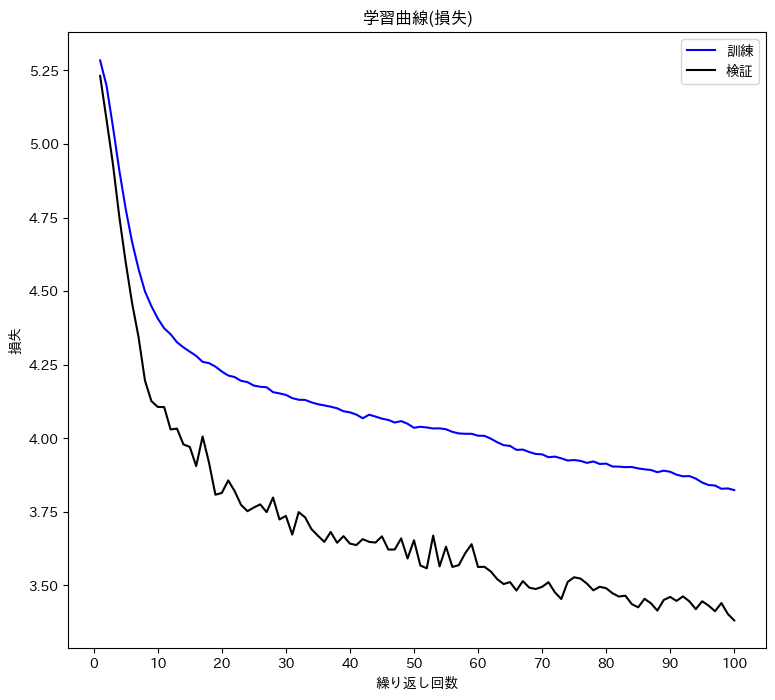

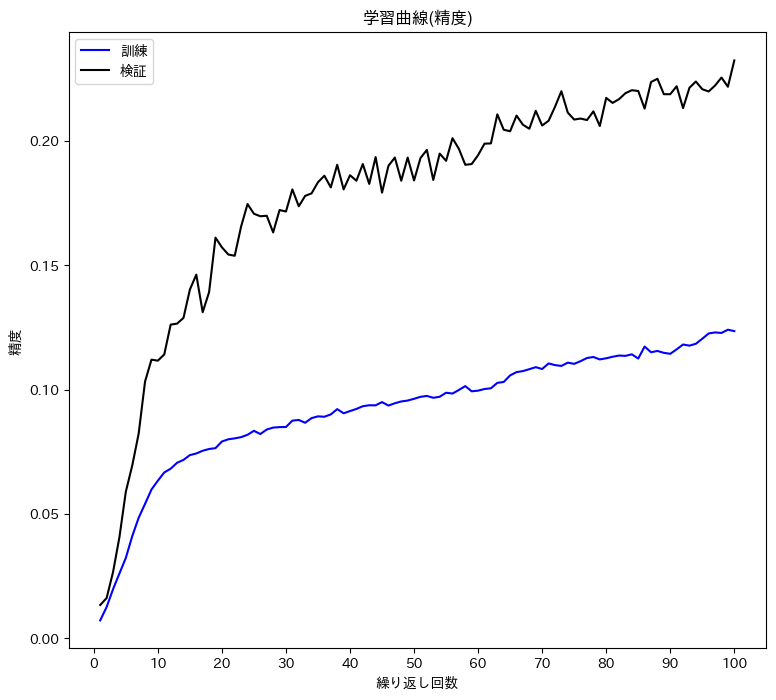

In [26]:
torch_seed()

# モデルインスタンス生成
net = CNN_v4(200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
history6 = np.zeros((0, 5))
num_epochs = 100
history6 = fit(net, optimizer, criterion, num_epochs, train_loader2, val_loader, device, history6)

evaluate_history(history6)

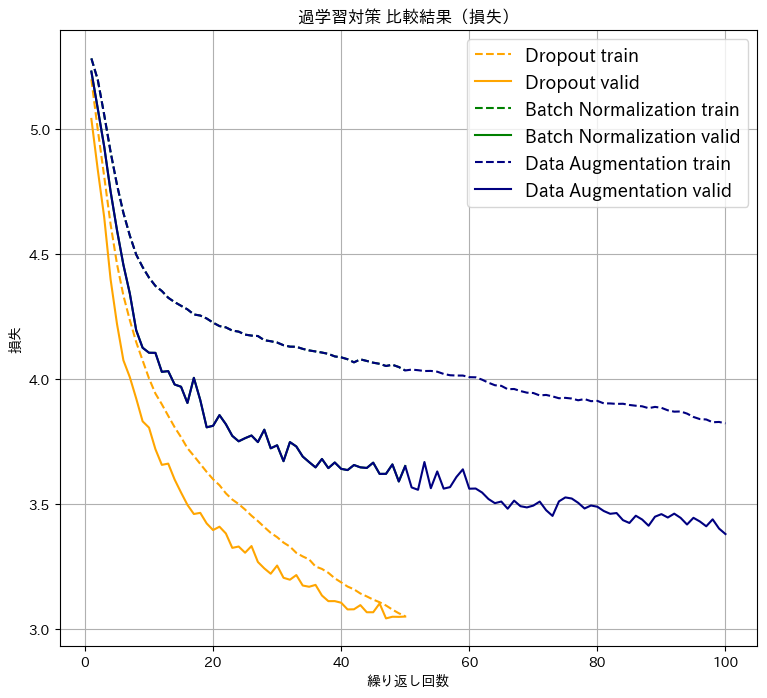

In [29]:
# 結果の比較(学習データへの精度)
plt.figure(figsize=(9,8))
plt.plot(history4[:,0], history4[:,1], label='Dropout train', c='orange', ls='dashed')
plt.plot(history4[:,0], history4[:,3], label='Dropout valid', c='orange')
plt.plot(history5[:,0], history5[:,1], label='Batch Normalization train', c='green', ls='dashed')
plt.plot(history5[:,0], history5[:,3], label='Batch Normalization valid', c='green')
plt.plot(history6[:,0], history6[:,1], label='Data Augmentation train', c='navy', ls='dashed')
plt.plot(history6[:,0], history6[:,3], label='Data Augmentation valid', c='navy')
plt.title('過学習対策 比較結果（損失）')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.grid()
plt.legend(fontsize = 13)
plt.show()

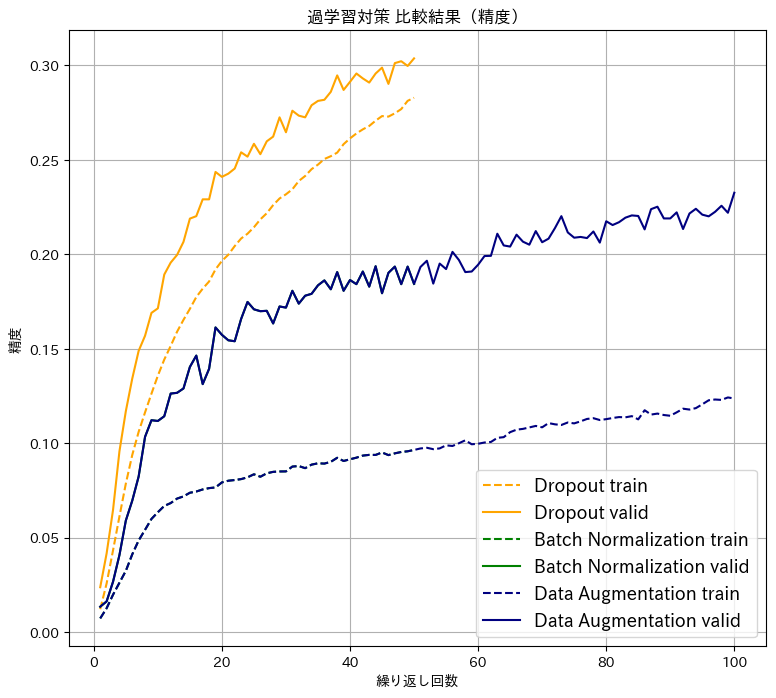

In [30]:
# 結果の比較(学習データへの精度)
plt.figure(figsize=(9,8))
plt.plot(history4[:,0], history4[:,2], label='Dropout train', c='orange', ls='dashed')
plt.plot(history4[:,0], history4[:,4], label='Dropout valid', c='orange')
plt.plot(history5[:,0], history5[:,2], label='Batch Normalization train', c='green', ls='dashed')
plt.plot(history5[:,0], history5[:,4], label='Batch Normalization valid', c='green')
plt.plot(history6[:,0], history6[:,2], label='Data Augmentation train', c='navy', ls='dashed')
plt.plot(history6[:,0], history6[:,4], label='Data Augmentation valid', c='navy')
plt.title('過学習対策 比較結果（精度）')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.grid()
plt.legend(fontsize = 13)
plt.show()

# VGG構造学習

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define the transform for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# Define DataLoader
batch_size = 100
train_loader_water = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [17]:
import torch
import torch.nn as nn
import os

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=200):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    @staticmethod
    def save_checkpoint(epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

    @staticmethod
    def load_checkpoint(path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

# Usage
model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200)


In [19]:
import torch
import torch.optim as optim
from sklearn.metrics import accuracy_score

def fit(model, optimizer, criterion, num_epochs, train_loader, val_loader, device, history):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_corrects += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / val_total

        # Save history
        history = np.append(history, [[epoch + 1, epoch_loss, epoch_acc, val_loss, val_acc]], axis=0)

        print(f'Epoch [{epoch + 1}/{num_epochs}]')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return history


Epoch [1/50]
Train Loss: 4.3242, Train Acc: 0.0969
Val Loss: 4.1191, Val Acc: 0.1226
Epoch [2/50]
Train Loss: 3.9062, Train Acc: 0.1550
Val Loss: 3.5103, Val Acc: 0.2135
Epoch [3/50]
Train Loss: 3.2874, Train Acc: 0.2488
Val Loss: 3.2678, Val Acc: 0.2562
Epoch [4/50]
Train Loss: 2.9308, Train Acc: 0.3111
Val Loss: 3.0938, Val Acc: 0.2913
Epoch [5/50]
Train Loss: 2.5554, Train Acc: 0.3794
Val Loss: 3.1016, Val Acc: 0.2962
Epoch [6/50]
Train Loss: 2.1103, Train Acc: 0.4684
Val Loss: 3.1946, Val Acc: 0.3027
Epoch [7/50]
Train Loss: 1.5709, Train Acc: 0.5830
Val Loss: 3.4958, Val Acc: 0.2996
Epoch [8/50]
Train Loss: 0.9929, Train Acc: 0.7158
Val Loss: 4.1322, Val Acc: 0.2838
Epoch [9/50]
Train Loss: 0.5767, Train Acc: 0.8271
Val Loss: 4.9028, Val Acc: 0.2686
Epoch [10/50]
Train Loss: 0.4006, Train Acc: 0.8753
Val Loss: 5.6604, Val Acc: 0.2690
Epoch [11/50]
Train Loss: 0.3307, Train Acc: 0.8972
Val Loss: 5.7415, Val Acc: 0.2644
Epoch [12/50]
Train Loss: 0.2806, Train Acc: 0.9118
Val Loss: 6

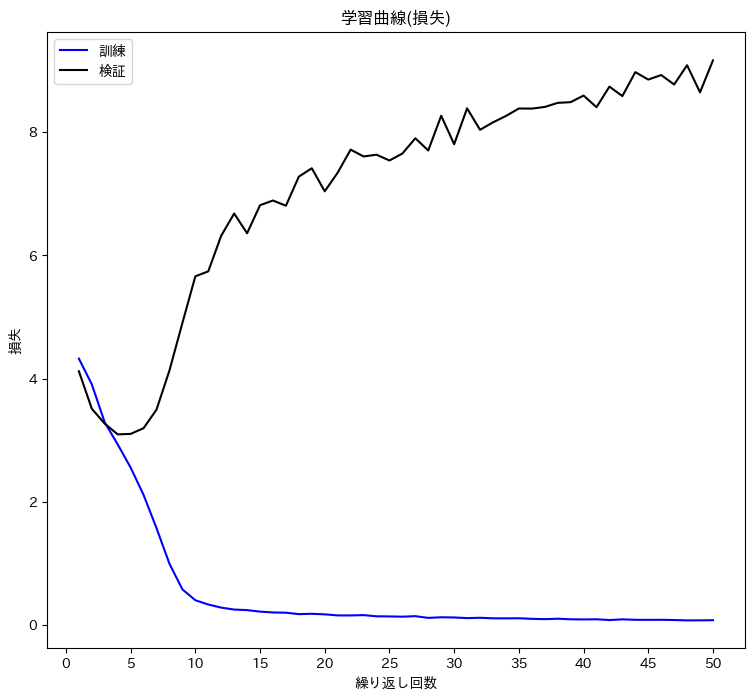

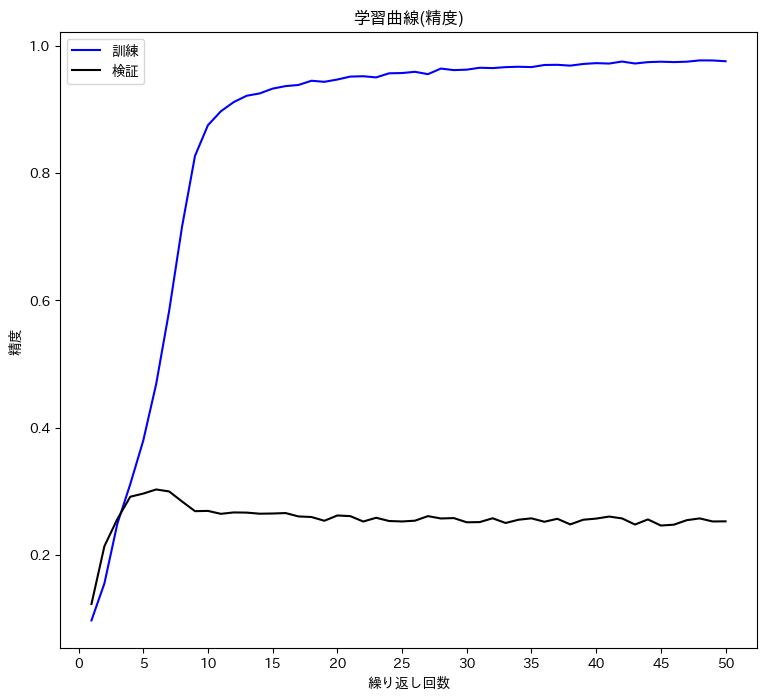

In [23]:
import numpy as np
import torch
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import torch.optim as optim
import numpy as np

# 乱数の固定化
seed_everything()

# モデルインスタンス生成
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 訓練と検証
num_epochs = 50
history8 = np.zeros((0, 5))
history8 = fit(net, optimizer, criterion, num_epochs, train_loader_water, val_loader, device, history8)

# 評価履歴の表示
evaluate_history(history8)

# チェックポイントの保存
net.save_checkpoint(num_epochs, net, optimizer, history8)
